# IMC-Denoise: a content aware denoising pipeline to enhance imaging mass cytometry

Here we will show an example for denoising the images with marker CD14 from our own human bone marrow IMC dataset. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IMC_Denoise.DeepSNF_utils.DeepSNF_DataGenerator import DeepSNF_DataGenerator, load_training_patches
from IMC_Denoise.IMC_Denoise_main.DeepSNF import DeepSNF

Using TensorFlow backend.


### Training data preparation
Next, we use our raw images to build a training set.
Note: 
1. The channel name must be consistant with the corresponding channel name in the image file names. For example, in our dataset, CD14 is conjucted with 144Nd. If the images with marker CD14 need to be denoised, the channel name will be set as its isotope name "144Nd".
2. Raw_directory is the folder of all the raw images used for generating training set. Its subfolders are the imagesets of different tissues. The subfolders contains the images from all the channels of the same tissue. 
<b><br>Data_structure example:
<b><br>|---Raw_image_directory
<br>|---|---Tissue1
<br>|---|---|---Channel1_img.tiff
<br>|---|---|---Channel2_img.tiff
<br>             ...
<br>|---|---|---Channel_n_img.tiff
<br>|---|---Tissue2
<br>|---|---|---Channel1_img.tiff
<br>|---|---|---Channel2_img.tiff
<br>             ...
<br>|---|---|---Channel_n_img.tiff
<br>             ...
<br>|---|---Tissue_m
<br>|---|---|---Channel1_img.tiff
<br>|---|---|---Channel2_img.tiff
<br>             ...
<br>|---|---|---Channel_n_img.tiff
</b>
3. Save_directory is the folder used for saving generated training data. If None, it will be saved in the default folder. For CD14, the saved training set is "training_set_144Nd.npz".
4. n_neighbour and n_lambda are the parameters from DIMR algorithm for hot pixel removal in the training set generation process. 4 and 5 are their defaults. If the defaults are changed, the corresponding parameter should be declared in DeepSNF_DataGenerator(). Otherwise, they can be omitted.
5. The DeepSNF_DataGenerator class search all the CD14 images in raw image directory, split them into multiple 64x64 patches, and then augment the generated data. Note the very sparse patches are removed in this process.
6. Here we will save the generated training set and later reload it.

In [2]:
# Release memory
if 'generated_patches' in globals():
    del generated_patches
    
channel_name = "144Nd"
Raw_directory = "D:\python_file_folder\IMC_learning\IMC_Denoise\Raw_IMC_for_training"
Save_directory = None # If None, it will be saved in the default folder.

n_neighbours = 4 # Larger n enables removing more consecutive hot pixels. 
n_lambda = 5 # Smaller n enables removing more hot pixels but may also generate false negatives. 

DataGenerator = DeepSNF_DataGenerator(channel_name = channel_name, n_neighbours = n_neighbours, n_lambda = n_lambda)
generated_patches = DataGenerator.generate_patches_from_directory(load_directory = Raw_directory)
if DataGenerator.save_patches(generated_patches, save_directory = Save_directory):
    print('Data generated successfully!')

Image data loaded from ...

D:\python_file_folder\IMC_learning\IMC_Denoise\Raw_IMC_for_training\Tissue1\144Nd-CD14_Nd144.tiff
D:\python_file_folder\IMC_learning\IMC_Denoise\Raw_IMC_for_training\Tissue10\144Nd-CD14_Nd144.tiff
D:\python_file_folder\IMC_learning\IMC_Denoise\Raw_IMC_for_training\Tissue2\144Nd-CD14_Nd144.tiff
D:\python_file_folder\IMC_learning\IMC_Denoise\Raw_IMC_for_training\Tissue3\144Nd-CD14_Nd144.tiff
D:\python_file_folder\IMC_learning\IMC_Denoise\Raw_IMC_for_training\Tissue4\144Nd-CD14_Nd144.tiff
D:\python_file_folder\IMC_learning\IMC_Denoise\Raw_IMC_for_training\Tissue5\144Nd-CD14_Nd144.tiff
D:\python_file_folder\IMC_learning\IMC_Denoise\Raw_IMC_for_training\Tissue6\144Nd-CD14_Nd144.tiff
D:\python_file_folder\IMC_learning\IMC_Denoise\Raw_IMC_for_training\Tissue7\144Nd-CD14_Nd144.tiff
D:\python_file_folder\IMC_learning\IMC_Denoise\Raw_IMC_for_training\Tissue8\144Nd-CD14_Nd144.tiff
D:\python_file_folder\IMC_learning\IMC_Denoise\Raw_IMC_for_training\Tissue9\144Nd-CD14_Nd

### Show several generated patches of the training set: Anscombe transformed.

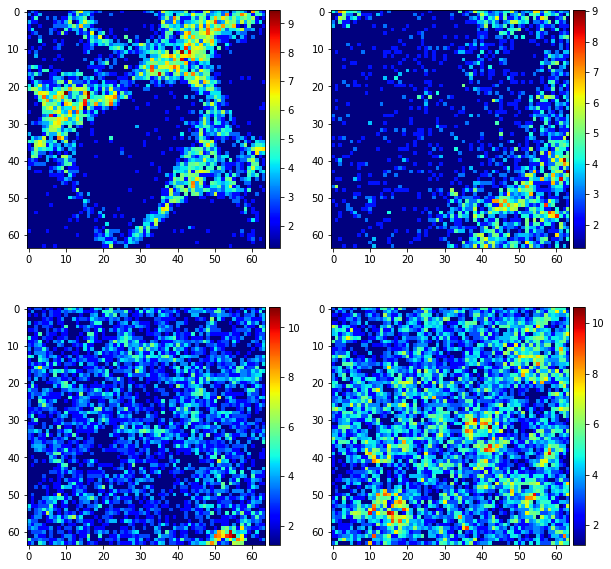

In [3]:
# show several generated patches of the training set, Anscombe transformed.
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(221)
im1 = ax1.imshow(generated_patches[0,:,:], cmap = 'jet')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax2 = fig.add_subplot(222)
im2 = ax2.imshow(generated_patches[100,:,:], cmap = 'jet')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

ax3 = fig.add_subplot(223)
im3 = ax3.imshow(generated_patches[1000,:,:], cmap = 'jet')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical')

ax4 = fig.add_subplot(224)
im4 = ax4.imshow(generated_patches[-1,:,:], cmap = 'jet')
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax, orientation='vertical')

### Load the generated training data from directory

In [4]:
saved_training_set = 'training_set_144Nd.npz'
train_data = load_training_patches(filename = saved_training_set, save_directory = Save_directory)
print('The shape of the loaded training set is ' + str(train_data.shape))

The shape of the loaded training set is (20704, 64, 64)


### DeepSNF configuration and training
Define parameters for DeepSNF training. If is_load_weights is True, the pre-trained model and pre-calculated range of the marker channel will be loaded. The range value is used for normalization in prediction.

In [5]:
train_epoches = 30 # training epoches, which should be at least 100 for a good training result. The default is 100.
train_initial_lr = 5e-4 # inital learning rate. The default is 5e-4.
train_batch_size = 256 # training batch size. For a GPU with smaller memory, it can be tuned smaller. The default is 256.
pixel_mask_percent = 0.2 # percentage of the masked pixels in each patch. The default is 0.2.
val_set_percent = 0.15 # percentage of validation set. The default is 0.15.
loss_function = "bce" # loss function used. The default is "bce".
weights_name = "weights_144Nd-CD14.hdf5" # trained network weights name. If None, the weights will not be saved.
loss_name = None # training and validation losses name, either .mat or .npz format. If not defined, the losses will not be saved.
weights_save_directory = None # location where 'weights_name' and 'loss_name' saved.
# If the value is None, the files will be saved in a sub-directory named "trained_weights" of the current file folder.
is_load_weights = False # Use the trained model directly. Will not read from any saved ones.
deepsnf = DeepSNF(train_epoches = train_epoches, 
                  train_learning_rate = train_initial_lr,
                  train_batch_size = train_batch_size,
                  mask_perc_pix = pixel_mask_percent,
                  val_perc = val_set_percent,
                  loss_func = loss_function,
                  weights_name = weights_name,
                  loss_name = loss_name,
                  weights_dir = weights_save_directory, 
                  is_load_weights = is_load_weights)

### Start training
If errors happen, check if the GPUs are being used by other sessions.

In [6]:
train_loss, val_loss = deepsnf.train(train_data)

The range value to the corresponding model is 14.38983137296266.
Input Channel Shape => (20704, 64, 64, 1)
Number of Training Examples: 17598
Number of Validation Examples: 3106
Each training patch with shape of (64, 64) will mask 8 pixels.
Training model...
Epoch 1/30
69/69 [==============================] - 73s 1s/step - loss: 0.4565 - val_loss: 0.4410

Epoch 00001: saving model to D:\IMC_Denoise\Jupyter_Notebook_examples\trained_weights\weights_144Nd-CD14.hdf5
Epoch 2/30
69/69 [==============================] - 51s 737ms/step - loss: 0.3091 - val_loss: 0.3175

Epoch 00002: saving model to D:\IMC_Denoise\Jupyter_Notebook_examples\trained_weights\weights_144Nd-CD14.hdf5
Epoch 3/30
69/69 [==============================] - 51s 739ms/step - loss: 0.2611 - val_loss: 0.2833

Epoch 00003: saving model to D:\IMC_Denoise\Jupyter_Notebook_examples\trained_weights\weights_144Nd-CD14.hdf5
Epoch 4/30
69/69 [==============================] - 51s 741ms/step - loss: 0.2467 - val_loss: 0.2693

Epoch 

### Plot the training and validation losses

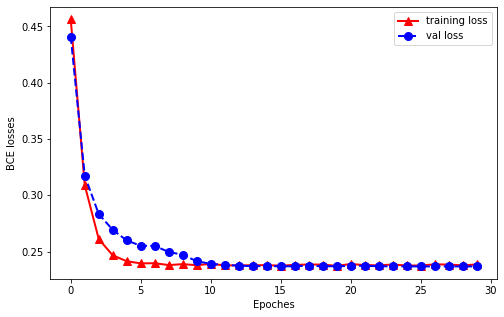

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(np.array(range(len(train_loss))),train_loss, color='red', marker='^', linewidth=2, markersize=8)
plt.plot(np.array(range(len(val_loss))),val_loss, color='blue', marker='o', linestyle='dashed', linewidth=2, markersize=8)
plt.xlabel('Epoches')
plt.ylabel('BCE losses')
plt.legend(['training loss', 'val loss'])
plt.show()